# THOUGHTS / COMMENTS / QUESTIONS ON THE PROJECT
* See line where we create corr_matrix -> one of my concerns is that we have 3 different columns that encapsulate weight
    * Whole Weight
    * Weight of Meat
    * Gut Weight (after bleeding)
    * Shell_Weight
        - If we build a model that includes all of these features, won't we have overlapping between the weights, especially with whole weight, since this weight is already encapsulated in pieces through each of the other weights (meat, gut, shell)? 
            - Should we remove this column to avoid overlapping and incorrectly fitting the model?
            
* Do I have to one-hot encode if I have 3 categories such as Sex: I/M/F ?
    Ex., I know I have to do it if category 1 may be closer to category 5, than category 1 is to category 2.

* I didn't use min-max scaling as the scales between the numerical data were really close, however, if we did implement min-max scaling we would likely get slighlty better results.

# Regression with an Abalone Dataset

In [1]:
%cd "C:\Users\Kyle\Desktop\Kaggle Project 2"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_log_error
from zlib import crc32
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200) #Allows us to see all columns

C:\Users\Kyle\Desktop\Kaggle Project 2


In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
train

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


## Step 1: Data Understanding

### An important comment about this project: The data is already split into training/test datasets, however, the test dataset does NOT have the label and values in it. Due to this, I will still be splitting the training dataset into an 80/20 split to test how well my model will generalize to new data. 

In [4]:
print("The shape of the training data is:", train.shape)
print("The shape of the testing data is:", test.shape)

The shape of the training data is: (90615, 10)
The shape of the testing data is: (60411, 9)


In [5]:
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [6]:
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


## Performance measured by RMSLE (Root Mean Squared Log Error)

**Based on the imported train/test datasets, we will be trying to predict the Rings.**

**Abalones are essentially sea snails that crawl around at the bottom of the ocean.** 

**Abalones grow their shells by adding layers of calcium carobonate over time. There can be many factors that affect the number of growth rings per abalone.** 

Some important details about the dataset:

**Columns**
  
   * Sex: M, F, and I (infant)
   * Length: Longest shell measurement (mm)
   * Diameter: perpendicular to length (mm)
   * Height: with meat in shell (mm)
   * Whole_weight: whole abalone (grams)
   * Whole_weight.1: weight of meat (grams)
   * Whole_weight.2: gut weight after bleeding (grams)
   * Shell weight: after being dried (grams)
   * Rings: +1.5 gives the age in years

In [7]:
train.dtypes

id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object

As a first step, it's important to check the data types of the columns and make corrections where needed.

In [8]:
train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


## Step 2: Data Preparation

In [9]:
train.nunique()

id                90615
Sex                   3
Length              157
Diameter            126
Height               90
Whole weight       3175
Whole weight.1     1799
Whole weight.2      979
Shell weight       1129
Rings                28
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


Great, so we aren't missing any data points here.

In [11]:
train['Sex'].value_counts()

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

In [12]:
test['Sex'].value_counts()

Sex
I    22241
M    20783
F    17387
Name: count, dtype: int64

In [13]:
print(f"The percent of Infant Abalones in train compared to total Abalones: {(train['Sex'] == 'I').sum() / len(train['Sex']) * 100:.2f}%")
print(f"The percent of Infant Abalones in test compared to total Abalones: {(test['Sex'] == 'I').sum() / len(test['Sex']) * 100:.2f}%")
print(f"The percent of Male Abalones in train compared to total Abalones: {(train['Sex'] == 'M').sum() / len(train['Sex']) * 100:.2f}%")
print(f"The percent of Male Abalones in test compared to total Abalones: {(test['Sex'] == 'M').sum() / len(test['Sex']) * 100:.2f}%")
print(f"The percent of Female Abalones in train compared to total Abalones: {(train['Sex'] == 'F').sum() / len(train['Sex']) * 100:.2f}%")
print(f"The percent of Female Abalones in test compared to total Abalones: {(test['Sex'] == 'F').sum() / len(test['Sex']) * 100:.2f}%")

The percent of Infant Abalones in train compared to total Abalones: 36.52%
The percent of Infant Abalones in test compared to total Abalones: 36.82%
The percent of Male Abalones in train compared to total Abalones: 34.24%
The percent of Male Abalones in test compared to total Abalones: 34.40%
The percent of Female Abalones in train compared to total Abalones: 29.24%
The percent of Female Abalones in test compared to total Abalones: 28.78%


Great! The purpose of the exercise above was to compare the distributions between the 'Sex' within the training and testing datasets. Since they have a similar distribution between both sets, we can assume that scaling was already done to ensure a similar distribution among both datasets. 

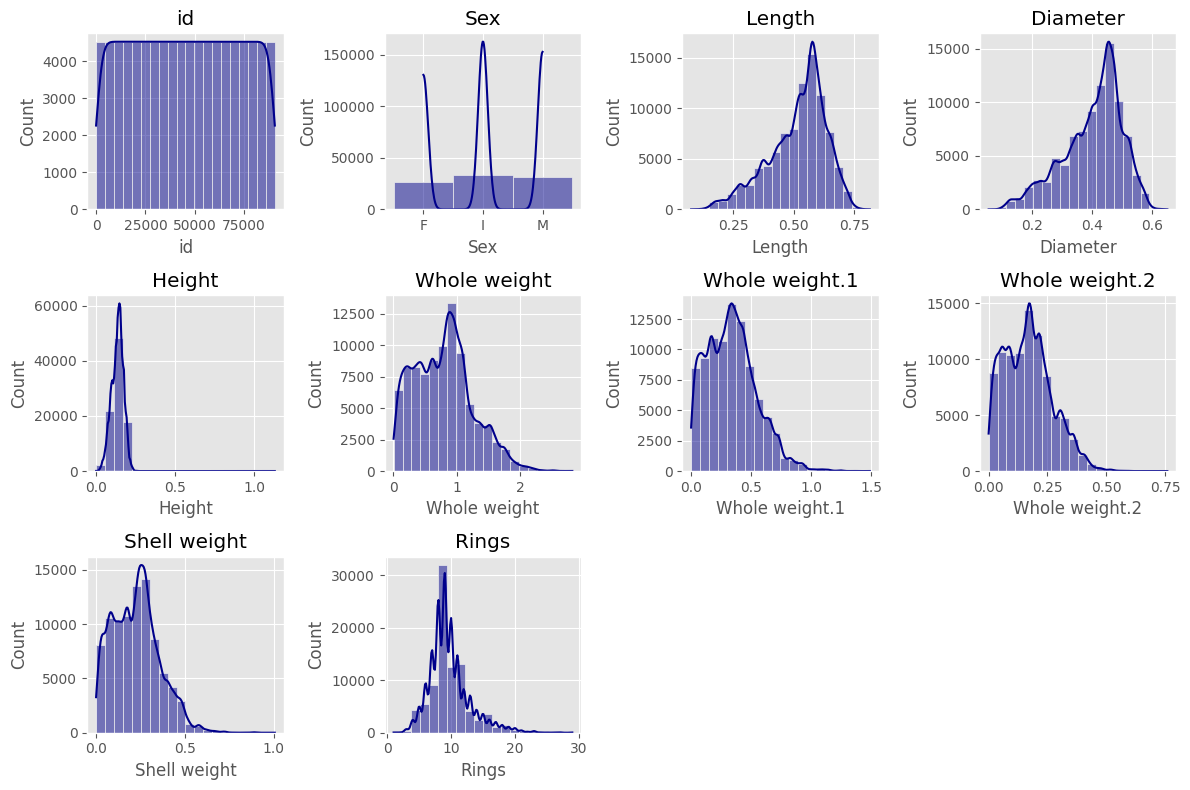

In [14]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(train.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(train[column], bins=20, kde=True, color='darkblue')
    plt.title(column)
plt.tight_layout()
plt.show()

<Axes: xlabel='Whole weight', ylabel='Height'>

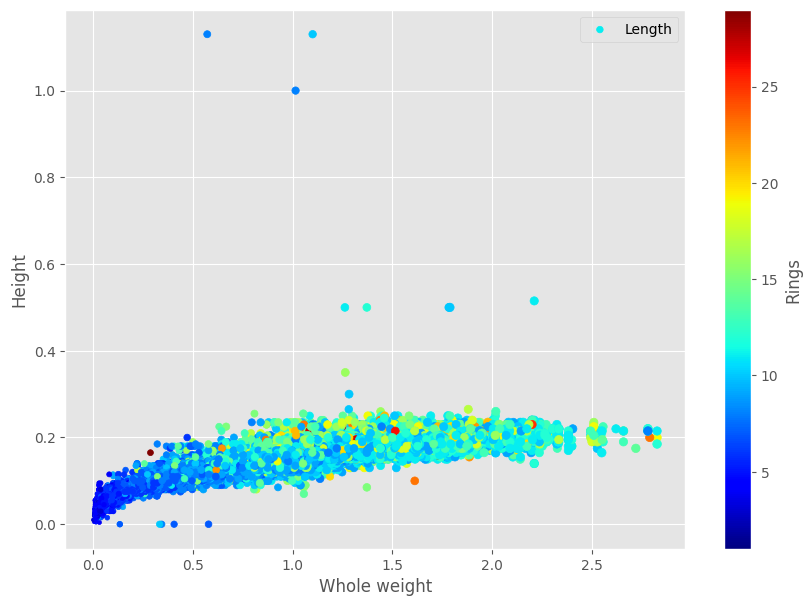

In [15]:
train.plot(kind = 'scatter', x = 'Whole weight', y = 'Height', grid=True,
           s = train['Length'] * 50, label = 'Length',
           c = 'Rings', cmap = 'jet', colorbar=True,
           legend = True, sharex = False, figsize = (10, 7))

Great! Based on our results, we can clear see a correlation between weight, height, and ring count. 

* A dead Abalone with a whole weight between 0 - .5 grams, is very likely to have under 10 rings.
* A dead Abalone with a height under .1 mm is extremely likely to have under 10 rings. 
* We can see we have a few outliers for height.

In [16]:
corr_matrix = train.corr(numeric_only = True)

corr_matrix['Rings'].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.694766
Height            0.665772
Diameter          0.636832
Length            0.623786
Whole weight      0.617274
Whole weight.2    0.588954
Whole weight.1    0.515067
id                0.000938
Name: Rings, dtype: float64

Since we only have one categorical column  ('Sex'), I want to convert this to a numerical column and re-run the corr_matrix to see the affect that 'Sex' has on the Ring count for the Abalones.

In [17]:
ordinal_encoder = OrdinalEncoder()

abalone_cat_encoded = ordinal_encoder.fit_transform(train[['Sex']])

#So, first we need to encode it to get the column into a numerical column, then we can 1-hot encode it so that it will view all options (I/M/F) as a similar distance apart from one another.

In [18]:
ordinal_encoder.categories_

# Here we can see the original array before it was transposed to numerical values.

[array(['F', 'I', 'M'], dtype=object)]

In [19]:
cat_encoder = OneHotEncoder()

abalone_cat_1hot = cat_encoder.fit_transform(train[['Sex']])

In [20]:
abalone_cat_1hot

#As we can see, it creates a sparse matrix which is meant to speed up computations (only remembers non-zero values)

<90615x3 sparse matrix of type '<class 'numpy.float64'>'
	with 90615 stored elements in Compressed Sparse Row format>

In [21]:
onehot_encoded_array = abalone_cat_1hot.toarray()

In [22]:
train

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


In [23]:
onehot_encoded_df = pd.DataFrame(onehot_encoded_array, columns=cat_encoder.get_feature_names_out(['Sex']))

onehot_encoded_df

,Sex_F,Sex_I,Sex_M
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
90610,0.0,0.0,1.0
90611,0.0,0.0,1.0
90612,0.0,1.0,0.0
90613,0.0,1.0,0.0


In [24]:
abalone_encoded = pd.concat([train.drop(columns=['Sex']), onehot_encoded_df], axis = 1)

In [25]:
abalone_encoded

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1.0,0.0,0.0
1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1.0,0.0,0.0
2,2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0.0,1.0,0.0
3,3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0.0,0.0,1.0
4,4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
90610,90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,0.0,0.0,1.0
90611,90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,0.0,0.0,1.0
90612,90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,0.0,1.0,0.0
90613,90613,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6,0.0,1.0,0.0


Perfect, now that we've one-hot encoded it, we can recheck the correlation between the features, and see what affect the sex has on the ring count.

In [26]:
corr_matrix = abalone_encoded.corr(numeric_only = True)

corr_matrix['Rings'].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.694766
Height            0.665772
Diameter          0.636832
Length            0.623786
Whole weight      0.617274
Whole weight.2    0.588954
Whole weight.1    0.515067
Sex_F             0.296411
Sex_M             0.240048
id                0.000938
Sex_I            -0.516591
Name: Rings, dtype: float64

Perfect! As we would expect, we have a negative correlation between the sex being infant and the ring count (age).

Also, the sex 'F' has a great correlation than the sex 'M', which is in line with general life expectancies among species. If we were visualize these data points, I would expect to see the female sex living longer than the male sex.

Side note: Although we assumed that the female sex would have the highest positive correlation and the infant sex to have the highest negative correlation, it's important to not introduce bias and have these assumptions without solid confirmation.

### Let's look into the distrubutions and how they're affected by various transformations!

In [27]:
abalone_encoded['Whole weight_sqrt'] = np.sqrt(abalone_encoded['Whole weight'])
abalone_encoded['Whole weight.1_sqrt'] = np.sqrt(abalone_encoded['Whole weight.1'])
abalone_encoded['Whole weight.2_sqrt'] = np.sqrt(abalone_encoded['Whole weight.2'])
abalone_encoded['Shell weight_sqrt'] = np.sqrt(abalone_encoded['Shell weight'])

small_const = 0.0001

abalone_encoded['Whole weight_log'] = np.log(abalone_encoded['Whole weight'] + small_const)
abalone_encoded['Whole weight.1_log'] = np.log(abalone_encoded['Whole weight.1'] + small_const)
abalone_encoded['Whole weight.2_log'] = np.log(abalone_encoded['Whole weight.2'] + small_const)
abalone_encoded['Shell weight_log'] = np.log(abalone_encoded['Shell weight'] + small_const)

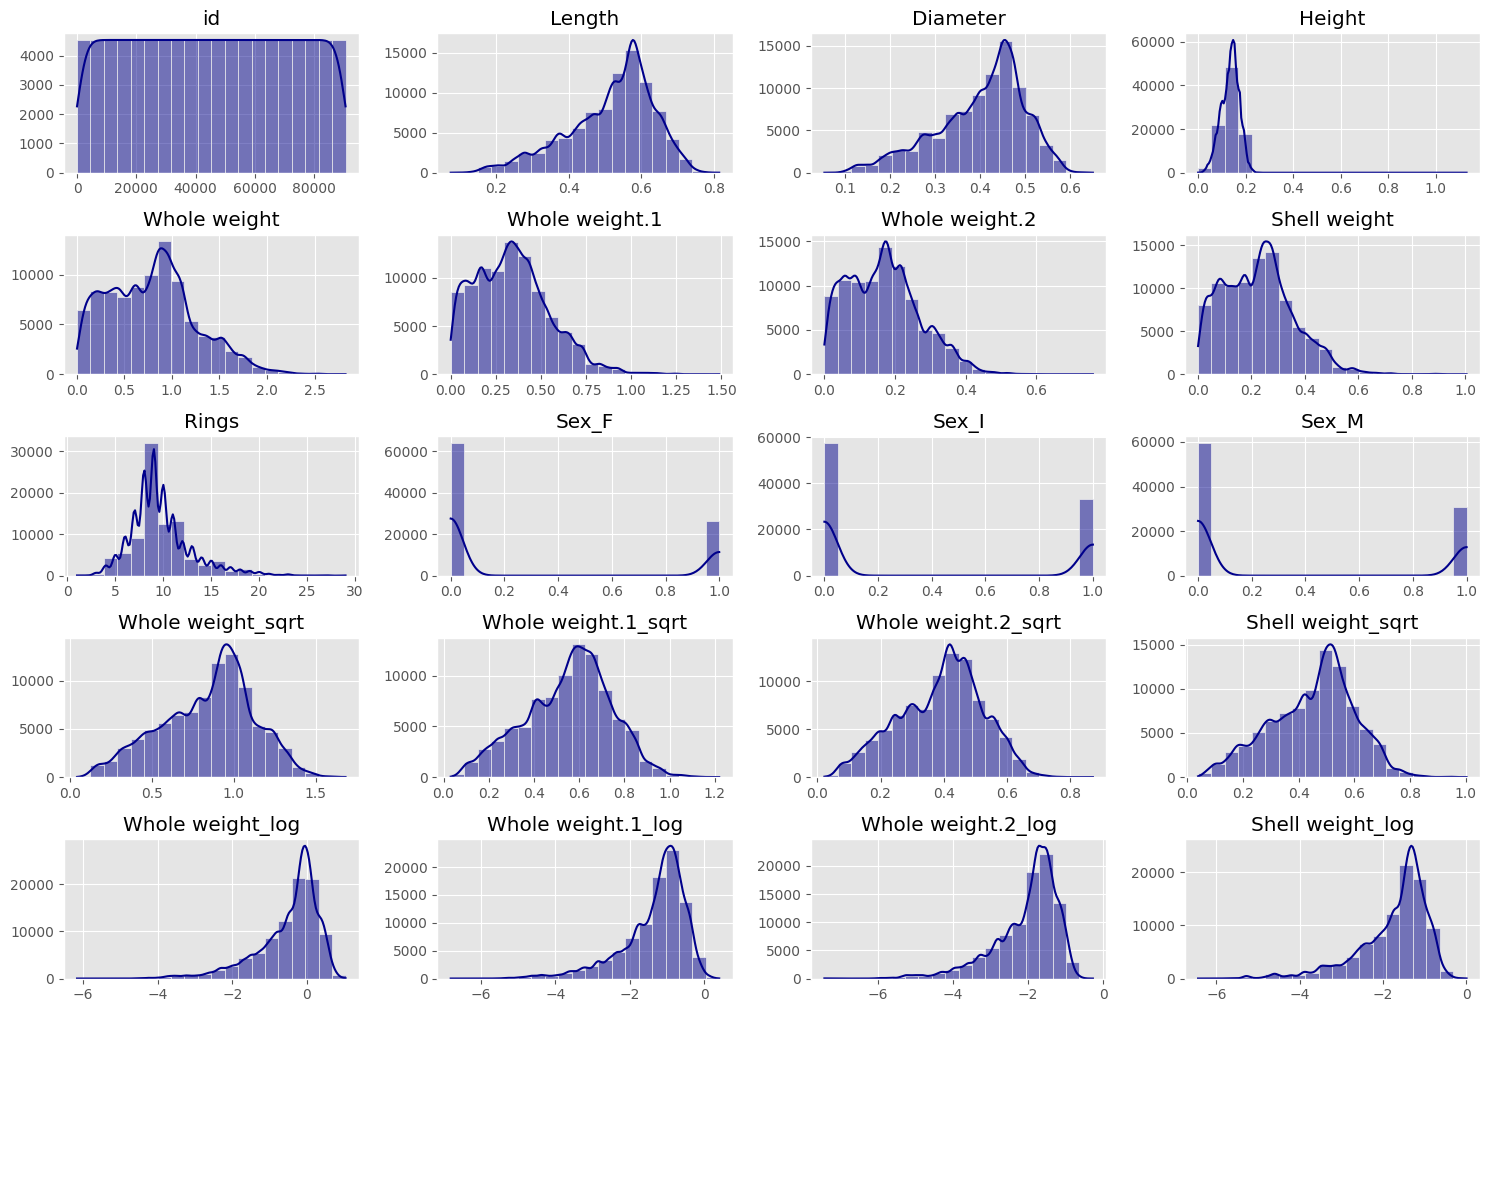

In [28]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 12))

axes = axes.flatten()

for i, column in enumerate(abalone_encoded.columns):
    sns.histplot(abalone_encoded[column], ax=axes[i], bins=20, color='darkblue', kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(abalone_encoded.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()

plt.show()

Great! What we ended up doing is testing all of the categories that don't have a close-to normal distribution, such as:

* Length
* Diameter
* Whole weight
* Whole weight.1
* Whole weight.2
* Shell weight

We ended up testing both the square-root and LOG of each column, comparing to the original column to see how the distribution was affected.  The only categories that I've kept within the code are:

* Whole weight
* Whole weight.1
* Whole weight.2
* Shell weight

This is because their new distribution by taking the square-root is more closely to a normal distribution than the original data.

Below I will remove the other unused columns that we created to view the distribution changes. Also, I will update our columns of Whole weight, Whole weight 1, Whole weight 2, and Shell weight to contain the values of the square root of the data, so that it represents a closerness to a normal distribution.

In [29]:
abalone_encoded['Whole weight'] = np.sqrt(abalone_encoded['Whole weight'])
abalone_encoded['Whole weight 1'] = np.sqrt(abalone_encoded['Whole weight.1'])
abalone_encoded['Whole weight 2'] = np.sqrt(abalone_encoded['Whole weight.2'])
abalone_encoded['Shell weight'] = np.sqrt(abalone_encoded['Shell weight'])

In [30]:
abalone_encoded.drop(['Whole weight.1', 'Whole weight.2', 'Whole weight_sqrt', 'Whole weight.1_sqrt', 'Whole weight.2_sqrt', \
                    'Shell weight_sqrt', 'Whole weight_log', 'Whole weight.1_log', 'Whole weight.2_log', 'Shell weight_log'], \
                    axis = 1, inplace=True)

In [31]:
abalone_encoded

,id,Length,Diameter,Height,Whole weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M,Whole weight 1,Whole weight 2
0,0,0.550,0.430,0.150,0.878351,0.489898,11,1.0,0.0,0.0,0.573149,0.382753
1,1,0.630,0.490,0.145,1.063015,0.565685,11,1.0,0.0,0.0,0.676757,0.525833
2,2,0.160,0.110,0.025,0.144914,0.070711,6,0.0,1.0,0.0,0.074162,0.054772
3,3,0.595,0.475,0.150,0.956295,0.500000,10,0.0,0.0,1.0,0.612781,0.453321
4,4,0.555,0.425,0.130,0.884308,0.444410,9,0.0,1.0,0.0,0.607865,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
90610,90610,0.335,0.235,0.075,0.398121,0.212132,6,0.0,0.0,1.0,0.261725,0.192354
90611,90611,0.555,0.425,0.150,0.937550,0.489898,9,0.0,0.0,1.0,0.621691,0.426028
90612,90612,0.435,0.330,0.095,0.567010,0.285482,6,0.0,1.0,0.0,0.388587,0.280179
90613,90613,0.345,0.270,0.075,0.447214,0.264575,6,0.0,1.0,0.0,0.313050,0.221359


In [32]:
new_column_order = [
    'id', 'Sex_I', 'Sex_F', 'Sex_M', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight 1', 'Whole weight 2', 'Shell weight', 'Rings'
]

abalone_encoded = abalone_encoded.reindex(columns=new_column_order)

In [33]:
abalone_encoded

,id,Sex_I,Sex_F,Sex_M,Length,Diameter,Height,Whole weight,Whole weight 1,Whole weight 2,Shell weight,Rings
0,0,0.0,1.0,0.0,0.550,0.430,0.150,0.878351,0.573149,0.382753,0.489898,11
1,1,0.0,1.0,0.0,0.630,0.490,0.145,1.063015,0.676757,0.525833,0.565685,11
2,2,1.0,0.0,0.0,0.160,0.110,0.025,0.144914,0.074162,0.054772,0.070711,6
3,3,0.0,0.0,1.0,0.595,0.475,0.150,0.956295,0.612781,0.453321,0.500000,10
4,4,1.0,0.0,0.0,0.555,0.425,0.130,0.884308,0.607865,0.400000,0.444410,9
...,...,...,...,...,...,...,...,...,...,...,...,...
90610,90610,0.0,0.0,1.0,0.335,0.235,0.075,0.398121,0.261725,0.192354,0.212132,6
90611,90611,0.0,0.0,1.0,0.555,0.425,0.150,0.937550,0.621691,0.426028,0.489898,9
90612,90612,1.0,0.0,0.0,0.435,0.330,0.095,0.567010,0.388587,0.280179,0.285482,6
90613,90613,1.0,0.0,0.0,0.345,0.270,0.075,0.447214,0.313050,0.221359,0.264575,6


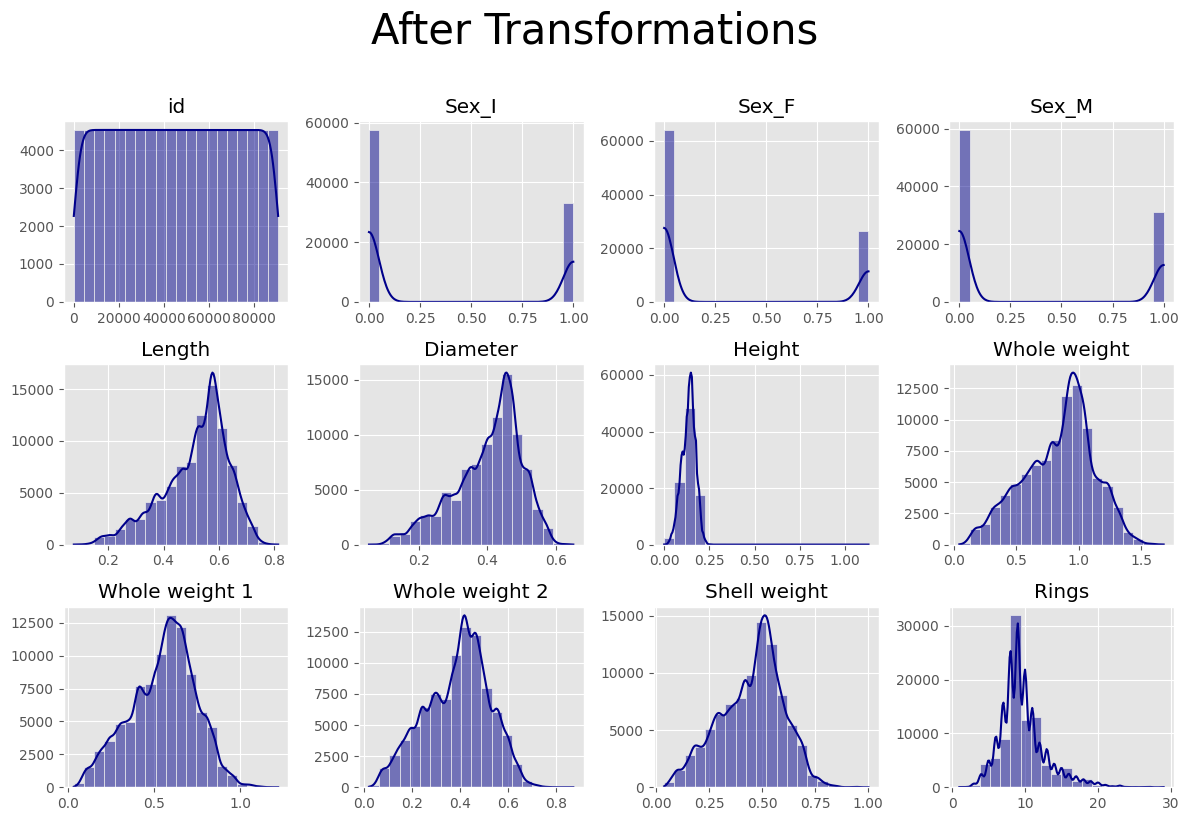

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

axes = axes.flatten()

for i, column in enumerate(abalone_encoded.columns):
    sns.histplot(abalone_encoded[column], ax=axes[i], bins=20, kde=True, color='darkblue')
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for k in range(len(abalone_encoded.columns), len(axes)):
    axes[k].axis('off')

plt.suptitle('After Transformations', fontsize=30, y=1.02)

plt.tight_layout()

plt.show()

C:\Users\Kyle\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


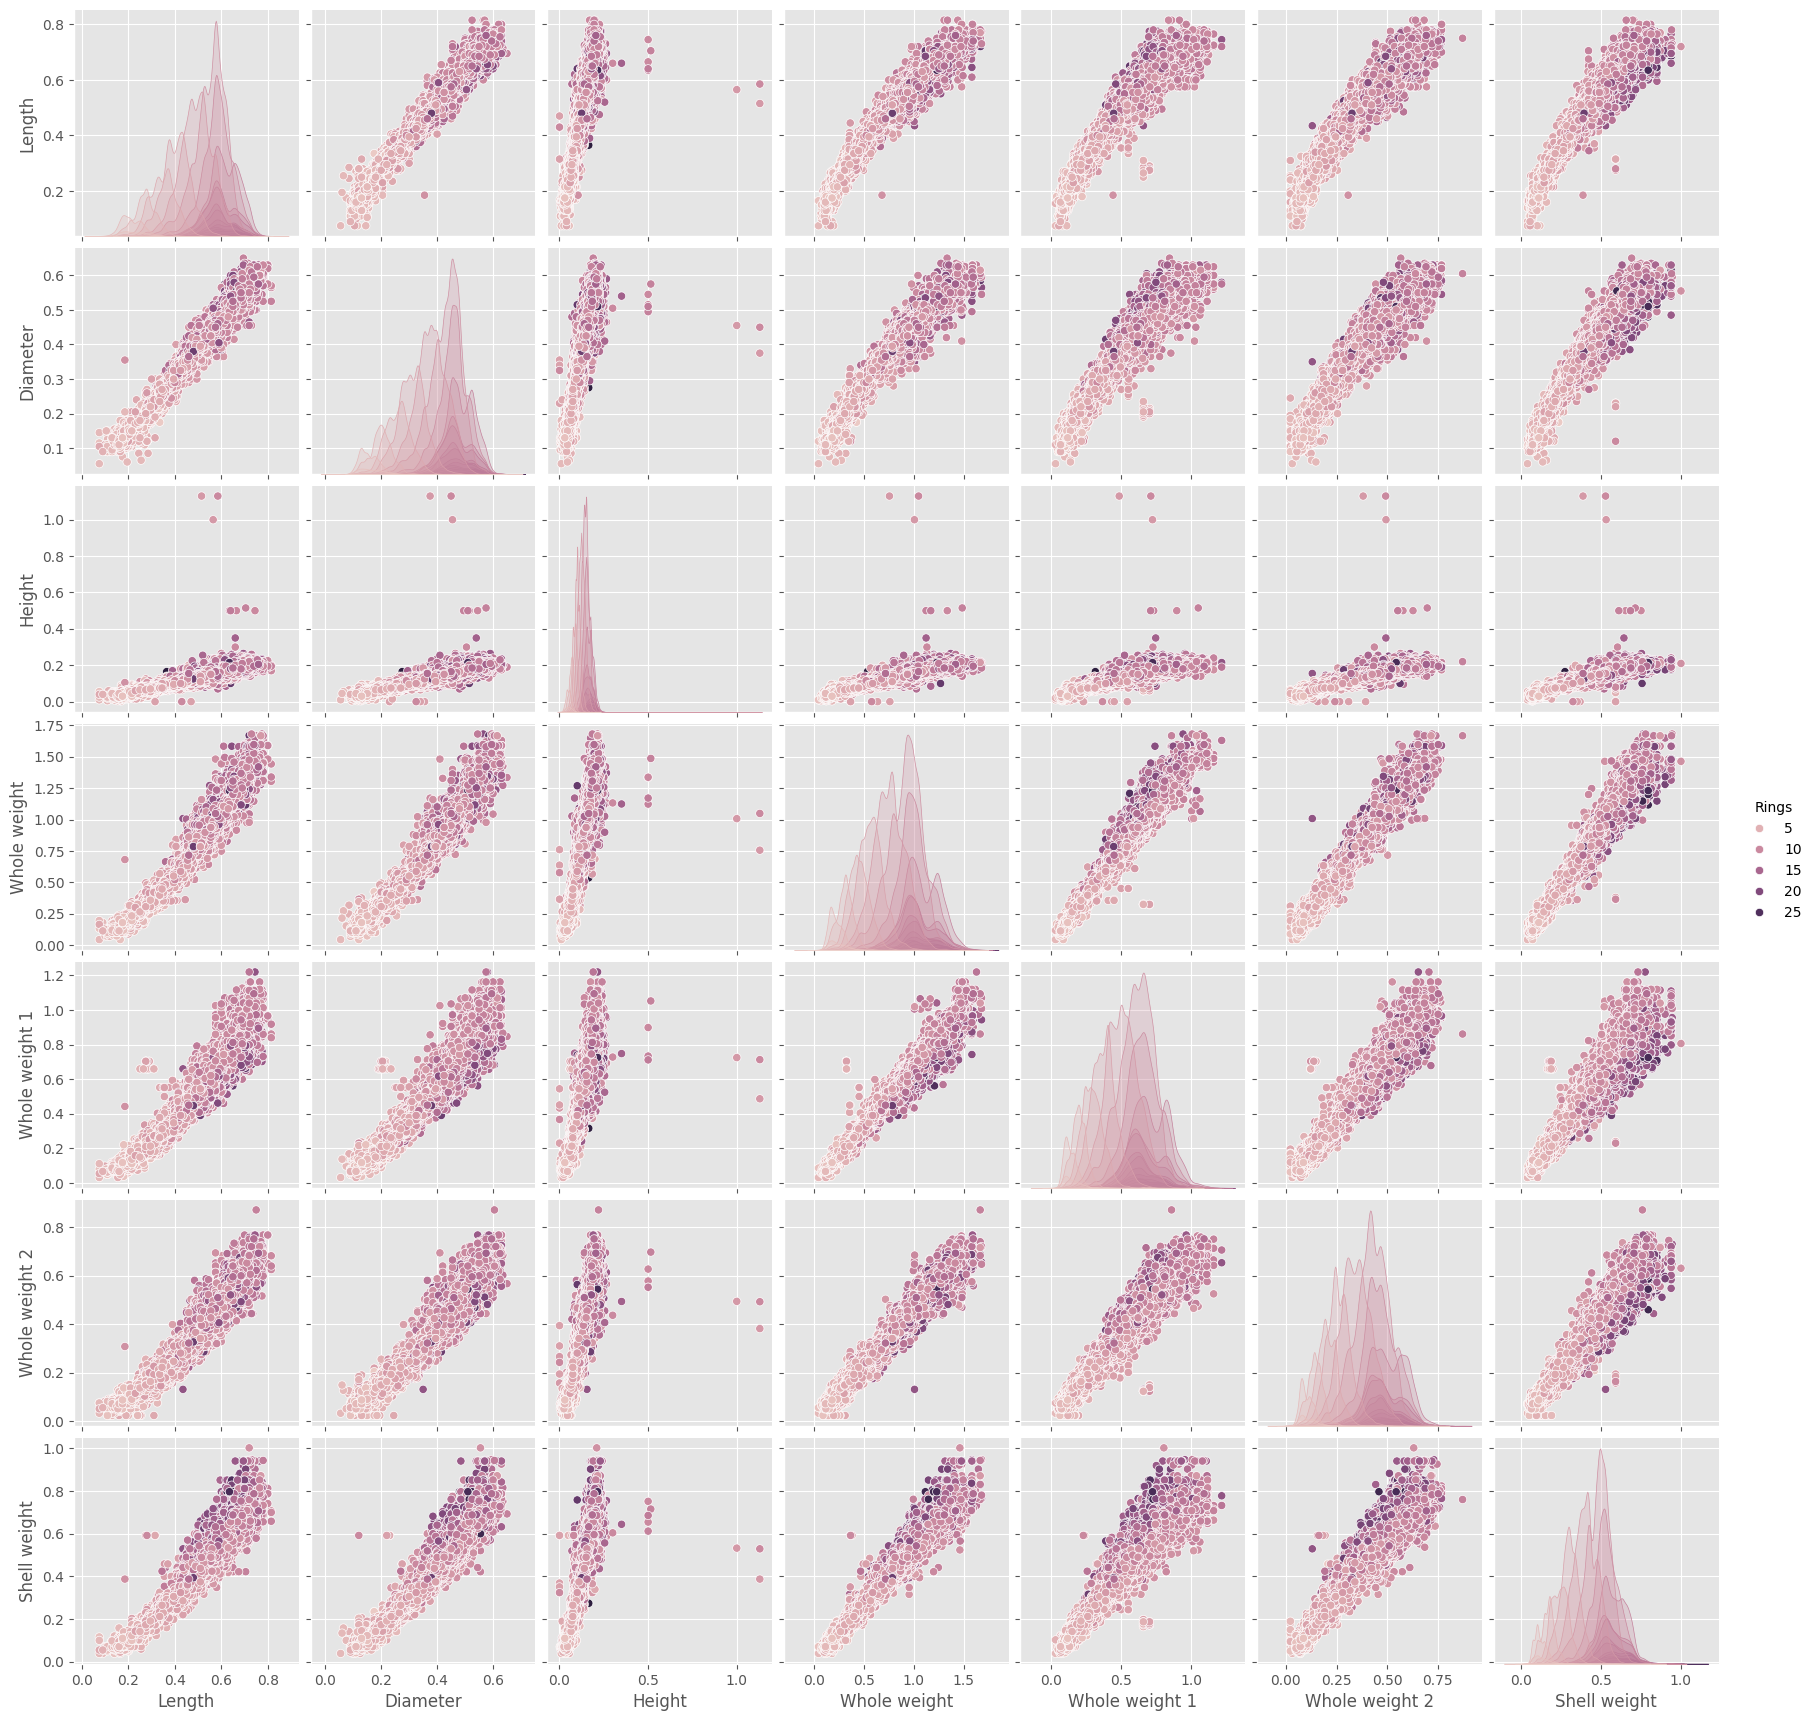

In [35]:
sns.pairplot(abalone_encoded, vars = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight 1', 
                                      'Whole weight 2', 'Shell weight'],
                                       hue='Rings')
plt.show()

Next up, splitting the dataset into an 80/20 ratio and applying stratified sampling. We will also be splitting off the column that we're trying to predict ['Rings'].

In [36]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [37]:
train_set, test_set = split_data_with_id_hash(abalone_encoded, .2, 'id')

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72493 entries, 0 to 90614
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              72493 non-null  int64  
 1   Sex_I           72493 non-null  float64
 2   Sex_F           72493 non-null  float64
 3   Sex_M           72493 non-null  float64
 4   Length          72493 non-null  float64
 5   Diameter        72493 non-null  float64
 6   Height          72493 non-null  float64
 7   Whole weight    72493 non-null  float64
 8   Whole weight 1  72493 non-null  float64
 9   Whole weight 2  72493 non-null  float64
 10  Shell weight    72493 non-null  float64
 11  Rings           72493 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 7.2 MB


In [38]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(abalone_encoded, abalone_encoded['Rings']):
    strat_train_set_n = abalone_encoded.iloc[train_index]
    strat_test_set_n = abalone_encoded.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    
strat_train_set, strat_test_set = strat_splits[0]

In [39]:
y_train = strat_train_set['Rings']
X_train = strat_train_set.drop('Rings', axis=1)

y_test = strat_test_set['Rings']
X_test = strat_test_set.drop('Rings', axis = 1)

Below we'll be comparing one column between the new train/test after we applied stratified sampling and ensuring we have a similar distribution of data points between all columns

In [40]:
strat_test_set['Length'].value_counts() / len(strat_test_set)

Length
0.575    0.035921
0.580    0.029024
0.550    0.024389
0.595    0.023009
0.600    0.023009
           ...   
0.274    0.000055
0.563    0.000055
0.411    0.000055
0.800    0.000055
0.815    0.000055
Name: count, Length: 139, dtype: float64

In [41]:
strat_train_set['Length'].value_counts() / len(strat_train_set)

Length
0.575    0.036087
0.580    0.029576
0.570    0.024430
0.550    0.023175
0.525    0.022430
           ...   
0.747    0.000014
0.374    0.000014
0.105    0.000014
0.528    0.000014
0.347    0.000014
Name: count, Length: 152, dtype: float64

Now we will create the model (Linear Regression), and implement crossfold validation.

In [42]:
model = LinearRegression()

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.maximum(0, y_true), np.maximum(0, y_pred)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(model, X_train, y_train, cv=kf)

rmsle_scores = rmsle(y_train, y_pred_cv)

mean_rmsle = np.mean(rmsle_scores)

print("Mean RMSLE Score:", mean_rmsle)

Mean RMSLE Score: 0.1646207521603588


Great, now let's fit the model on the training dataset, and then make predictions on the test data set. We will then calculate the RMSLE score to see how well it's performing on the test data set.

In [43]:
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

rmsle_test = rmsle(y_test, y_pred_test)

print("RMSLE Score on Test Set:", rmsle_test)

RMSLE Score on Test Set: 0.16565393513239524


Since our RMSLE score is similar between the training / testing datasets, it appears to be generalizing well to new data.

Now that we've trained our model and confirmed it generalizes well, let's begin to work on our testing dataset and use the model to predict the Rings. We will need to apply the same transformations, such as changing the distribution.

In [44]:
test['Whole weight'] = np.sqrt(test['Whole weight'])
test['Whole weight 1'] = np.sqrt(test['Whole weight.1'])
test['Whole weight 2'] = np.sqrt(test['Whole weight.2'])
test['Shell weight'] = np.sqrt(test['Shell weight'])

In [45]:
abalone_test_cat_encoded = ordinal_encoder.fit_transform(test[['Sex']])

abalone_test_cat_1hot = cat_encoder.fit_transform(test[['Sex']])

onehot_encoded_array_test = abalone_test_cat_1hot.toarray()

onehot_encoded_test_df = pd.DataFrame(onehot_encoded_array_test, columns=cat_encoder.get_feature_names_out(['Sex']))

onehot_encoded_test_df

,Sex_F,Sex_I,Sex_M
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
60406,0.0,1.0,0.0
60407,1.0,0.0,0.0
60408,0.0,1.0,0.0
60409,1.0,0.0,0.0


In [46]:
test_encoded = pd.concat([test.drop(columns=['Sex']), onehot_encoded_test_df], axis = 1)

test_encoded

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Whole weight 1,Whole weight 2,Sex_F,Sex_I,Sex_M
0,90615,0.645,0.475,0.155,1.112654,0.6185,0.3125,0.548179,0.786448,0.559017,0.0,0.0,1.0
1,90616,0.580,0.460,0.160,0.991464,0.4785,0.2195,0.524404,0.691737,0.468508,0.0,0.0,1.0
2,90617,0.560,0.420,0.140,0.916242,0.3525,0.1845,0.490408,0.593717,0.429535,0.0,0.0,1.0
3,90618,0.570,0.490,0.145,0.934880,0.3525,0.1865,0.484768,0.593717,0.431856,0.0,0.0,1.0
4,90619,0.415,0.325,0.110,0.598331,0.1575,0.0670,0.324037,0.396863,0.258844,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,0.345,0.260,0.085,0.421307,0.0735,0.0265,0.223607,0.271109,0.162788,0.0,1.0,0.0
60407,151022,0.525,0.410,0.145,0.918967,0.3885,0.1670,0.452769,0.623298,0.408656,1.0,0.0,0.0
60408,151023,0.590,0.440,0.155,1.059245,0.3930,0.2000,0.514782,0.626897,0.447214,0.0,1.0,0.0
60409,151024,0.660,0.525,0.190,1.222088,0.5885,0.3575,0.659545,0.767138,0.597913,1.0,0.0,0.0


In [47]:
new_column_test_order = [
    'id', 'Sex_I', 'Sex_F', 'Sex_M', 'Length', 'Diameter', 'Height', 'Whole weight',\
    'Whole weight 1', 'Whole weight 2', 'Shell weight'
]

test_encoded = test_encoded.reindex(columns=new_column_test_order)

In [48]:
test_encoded

,id,Sex_I,Sex_F,Sex_M,Length,Diameter,Height,Whole weight,Whole weight 1,Whole weight 2,Shell weight
0,90615,0.0,0.0,1.0,0.645,0.475,0.155,1.112654,0.786448,0.559017,0.548179
1,90616,0.0,0.0,1.0,0.580,0.460,0.160,0.991464,0.691737,0.468508,0.524404
2,90617,0.0,0.0,1.0,0.560,0.420,0.140,0.916242,0.593717,0.429535,0.490408
3,90618,0.0,0.0,1.0,0.570,0.490,0.145,0.934880,0.593717,0.431856,0.484768
4,90619,1.0,0.0,0.0,0.415,0.325,0.110,0.598331,0.396863,0.258844,0.324037
...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,1.0,0.0,0.0,0.345,0.260,0.085,0.421307,0.271109,0.162788,0.223607
60407,151022,0.0,1.0,0.0,0.525,0.410,0.145,0.918967,0.623298,0.408656,0.452769
60408,151023,1.0,0.0,0.0,0.590,0.440,0.155,1.059245,0.626897,0.447214,0.514782
60409,151024,0.0,1.0,0.0,0.660,0.525,0.190,1.222088,0.767138,0.597913,0.659545


In [49]:
predicted_rings = model.predict(test_encoded)
predicted_rings= np.round(predicted_rings)
predicted_rings = predicted_rings.astype(int)

predicted_data = pd.DataFrame({'id': test_encoded['id'], 'Rings': predicted_rings})

predicted_data

,id,Rings
0,90615,9
1,90616,10
2,90617,10
3,90618,10
4,90619,8
...,...,...
60406,151021,7
60407,151022,9
60408,151023,11
60409,151024,13


In [50]:
predicted_data.to_csv('predicted_rings.csv', index=False)